# 20기 Clustering 정규세션 과제

**데이터:** [Mall Customer Segmentation Data| Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

---

## 0. 데이터 불러오기

In [1]:
import pandas as pd
df = pd.read_csv("Mall_Customers.csv", index_col = 0)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


## 1. Preprocssing / EDA

EDA

In [2]:
missing_values = df.isnull().sum()
missing_values

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [3]:
numerical_stats_mall = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].describe()
numerical_stats_mall

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


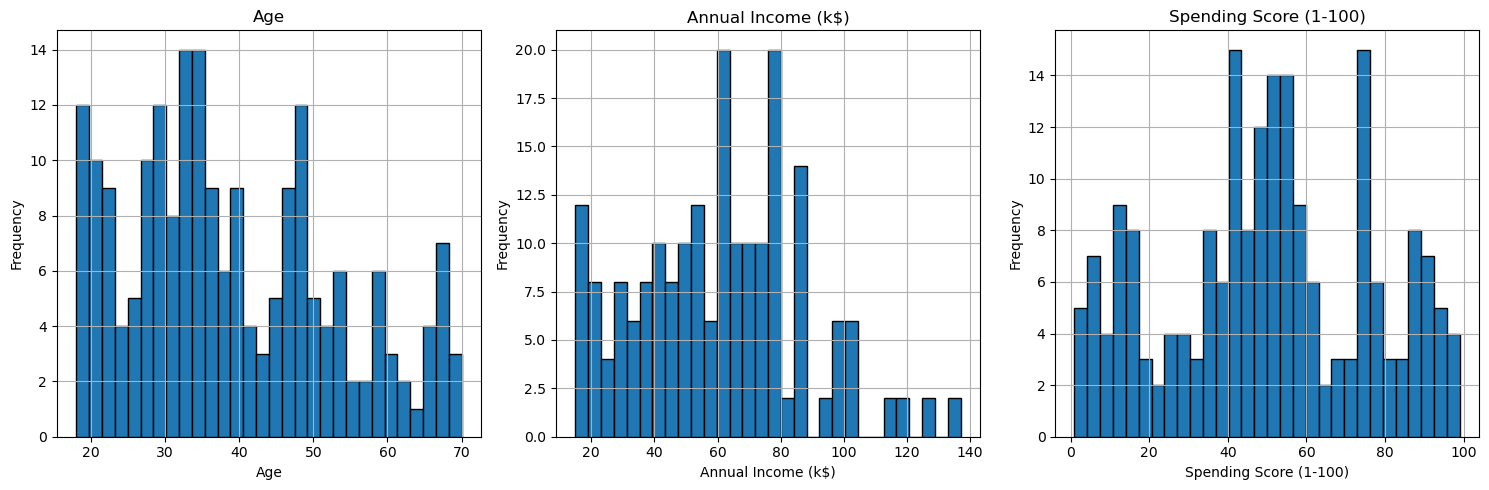

In [4]:
import matplotlib.pyplot as plt

numerical_columns_mall = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

plt.figure(figsize=(15, 5))

for i, col in enumerate(numerical_columns_mall, 1):
    plt.subplot(1, 3, i)
    df[col].hist(bins=30, edgecolor='black')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show()

In [5]:
gender_distribution = df['Gender'].value_counts()
gender_distribution

Female    112
Male       88
Name: Gender, dtype: int64

In [6]:
correlation_matrix_mall = df[numerical_columns_mall].corr()
correlation_matrix_mall

,Age,Annual Income (k$),Spending Score (1-100)
Age,1.000000,-0.012398,-0.327227
Annual Income (k$),-0.012398,1.000000,0.009903
Spending Score (1-100),-0.327227,0.009903,1.000000


Preprocessing

In [8]:
df_preprocess = df.copy()

df_preprocess = pd.get_dummies(df_preprocess, columns=['Gender'])

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_preprocess[numerical_columns_mall] = scaler.fit_transform(df_preprocess[numerical_columns_mall])
df_preprocess.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
CustomerID,,,,,
1,0.019231,0.000000,0.387755,0,1
2,0.057692,0.000000,0.816327,0,1
3,0.038462,0.008197,0.051020,1,0
4,0.096154,0.008197,0.775510,1,0
5,0.250000,0.016393,0.397959,1,0


## 2. Clustering

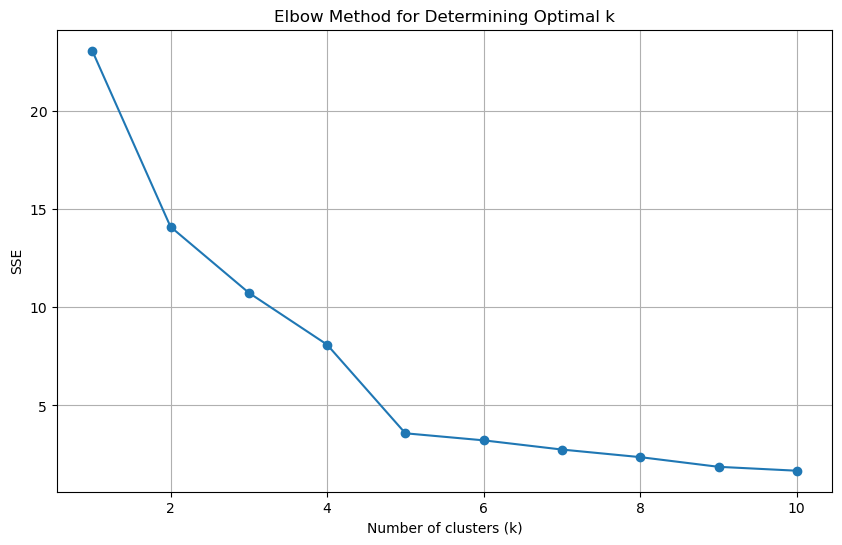

In [32]:
from sklearn.cluster import KMeans

X = df_preprocess[['Annual Income (k$)', 'Spending Score (1-100)']]

sse = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X)
    sse.append(kmeans.inertia_)
    
plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.title('Elbow Method for Determining Optimal k')
plt.grid(True)
plt.show()

In [33]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto').fit(X)
df_preprocess['Cluster'] = kmeans.labels_

df_preprocess.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male,Cluster
CustomerID,,,,,,
1,0.019231,0.000000,0.387755,0,1,2
2,0.057692,0.000000,0.816327,0,1,3
3,0.038462,0.008197,0.051020,1,0,2
4,0.096154,0.008197,0.775510,1,0,3
5,0.250000,0.016393,0.397959,1,0,2


## 3. Evaluation

In [34]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X, df_preprocess['Cluster'])
score

0.5594854531227246

In [35]:
from itertools import combinations
from scipy.spatial.distance import euclidean

def dunn_index(X, labels):
    intra_distances = []
    for label in set(labels):
        cluster_points = X[labels == label]
        if cluster_points.shape[0] > 1:
            intra_pairwise_distances = [euclidean(p1, p2) for p1, p2 in combinations(cluster_points, 2)]
            intra_distances.append(max(intra_pairwise_distances))

    inter_distances = []
    for label1, label2 in combinations(set(labels), 2):
        cluster1_points = X[labels == label1]
        cluster2_points = X[labels == label2]
        inter_pairwise_distances = [euclidean(p1, p2) for p1 in cluster1_points for p2 in cluster2_points]
        inter_distances.append(min(inter_pairwise_distances))

    if not intra_distances or not inter_distances:
        return 0
    
    return min(inter_distances) / max(intra_distances)

In [36]:
dunn = dunn_index(X.values, df_preprocess['Cluster'].values)
dunn

0.07245631660330355

In [45]:
from scipy.spatial import ConvexHull

def connect_to_centroid(ax, points, centroid, color):
    for point in points:
        ax.plot([point[0], centroid[0]], [point[1], centroid[1]], c=color, linestyle='--', linewidth=0.5)

def draw_hull(ax, subset, color):
    if subset.shape[0] < 3:  # A convex hull cannot be computed with less than 3 points
        return
    hull = ConvexHull(subset)
    for simplex in hull.simplices:
        ax.plot(subset.iloc[simplex, 0], subset.iloc[simplex, 1], color=color, linewidth=1.5)

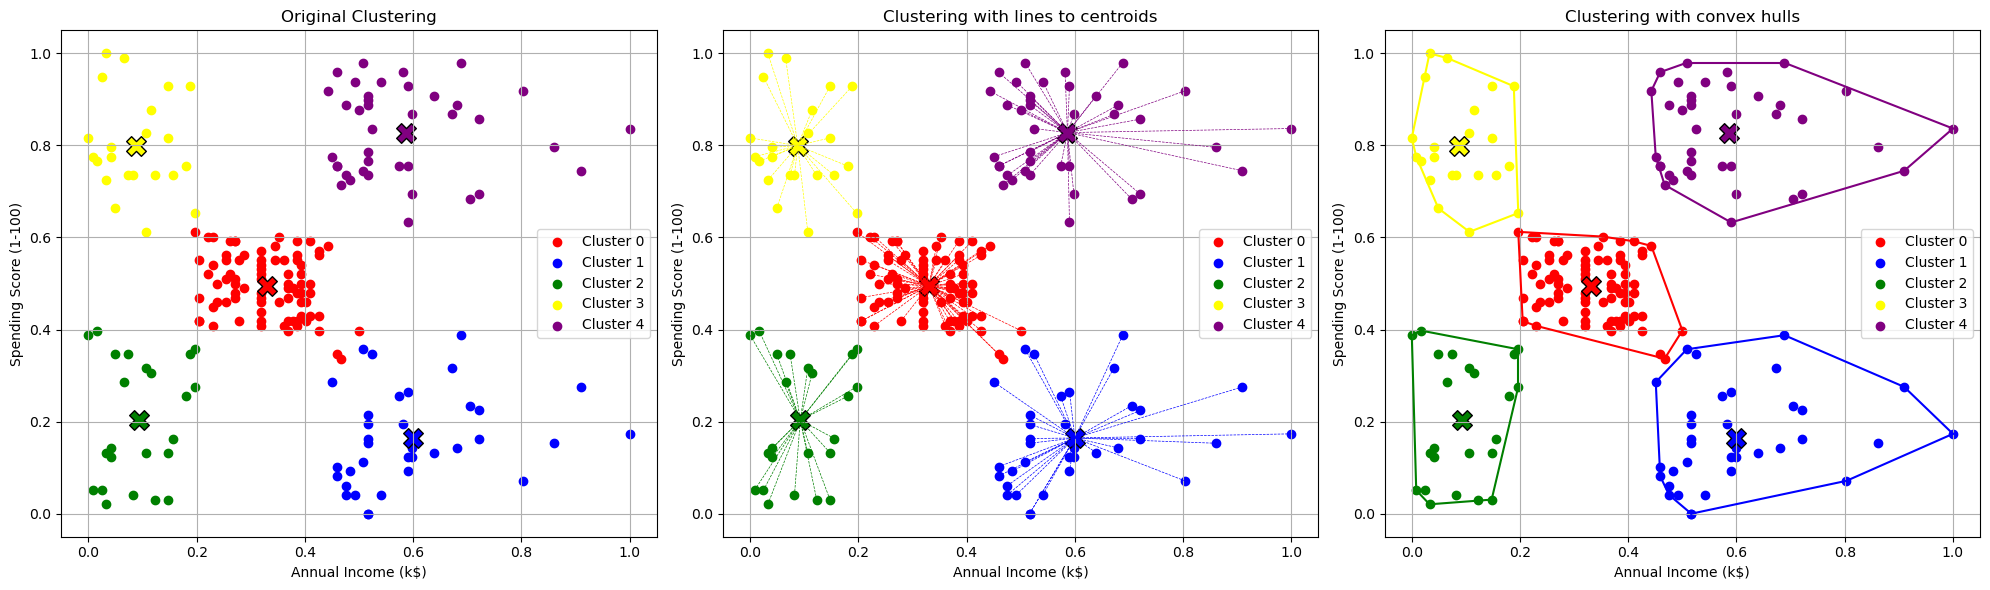

In [47]:
# Creating a figure with three horizontal subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
colors = ['red', 'blue', 'green', 'yellow', 'purple']

# 1. Original clustering
for cluster, color in zip(range(5), colors):
    subset = df_preprocess[df_preprocess['Cluster'] == cluster]
    axes[0].scatter(subset['Annual Income (k$)'], subset['Spending Score (1-100)'], color=color, label=f'Cluster {cluster}')
for cluster, color in zip(range(5), colors):
    axes[0].scatter(kmeans.cluster_centers_[cluster, 0], kmeans.cluster_centers_[cluster, 1], s=200, c=color, marker='X', edgecolors='k')
axes[0].set_xlabel('Annual Income (k$)')
axes[0].set_ylabel('Spending Score (1-100)')
axes[0].legend()
axes[0].set_title('Original Clustering')
axes[0].grid(True)

# 2. Clustering with lines connecting to the centroids
for cluster, color in zip(range(5), colors):
    subset = df_preprocess[df_preprocess['Cluster'] == cluster]
    axes[1].scatter(subset['Annual Income (k$)'], subset['Spending Score (1-100)'], color=color, label=f'Cluster {cluster}')
    connect_to_centroid(axes[1], subset[['Annual Income (k$)', 'Spending Score (1-100)']].values, kmeans.cluster_centers_[cluster], color)
for cluster, color in zip(range(5), colors):
    axes[1].scatter(kmeans.cluster_centers_[cluster, 0], kmeans.cluster_centers_[cluster, 1], s=200, c=color, marker='X', edgecolors='k')
axes[1].set_xlabel('Annual Income (k$)')
axes[1].set_ylabel('Spending Score (1-100)')
axes[1].legend()
axes[1].set_title('Clustering with lines to centroids')
axes[1].grid(True)

# 3. Clustering with convex hulls
for cluster, color in zip(range(5), colors):
    subset = df_preprocess[df_preprocess['Cluster'] == cluster][['Annual Income (k$)', 'Spending Score (1-100)']]
    axes[2].scatter(subset['Annual Income (k$)'], subset['Spending Score (1-100)'], color=color, label=f'Cluster {cluster}')
    draw_hull(axes[2], subset, color)
for cluster, color in zip(range(5), colors):
    axes[2].scatter(kmeans.cluster_centers_[cluster, 0], kmeans.cluster_centers_[cluster, 1], s=200, c=color, marker='X', edgecolors='k')
axes[2].set_xlabel('Annual Income (k$)')
axes[2].set_ylabel('Spending Score (1-100)')
axes[2].legend()
axes[2].set_title('Clustering with convex hulls')
axes[2].grid(True)

plt.tight_layout()
plt.show()
